Auto-Encoding Variational Bayes（AEVB）是一种将变分推断（Variational Inference）和自动编码器（Autoencoder）结合起来的方法，常用于无监督学习中的生成模型。它结合了变分自编码器（Variational Autoencoder, VAE）的思想，通过优化变分下界来近似后验分布。

变分贝叶斯是一种近似推断的技术，主要目的是用一个简单的分布来近似一个复杂的后验分布 $p(z \mid x)=\frac{p(x \mid z) p(z)}{p(x)}$。在实际问题中，计算后验分布是非常困难的，尤其是在高维空间中，所以我们用一个易于处理的变分分布来代替真实的后验分布。难算，是因为边际似然难算。

为什么边际似然 p(x) 的计算通常是非常困难的？
$$p(x)=\int p(x \mid z) p(z) d z$$
通过一个一维的简单例子来展示边际似然计算的困难。基于蒙特卡洛近似。

Dimension	Time(sec)	Marginal Likelihood
----------------------------------------
1	0.1124		0.0855730867343
2	0.2197		0.0054560288656
3	0.2729		0.0002257666480
4	0.3481		0.0000060617453
5	0.4126		0.0000001911159
6	0.4695		0.0000000108958
7	0.5373		0.0000000237142
8	0.6090		0.0000000017256
9	0.6949		0.0000000000076
10	0.7620		0.0000000000152


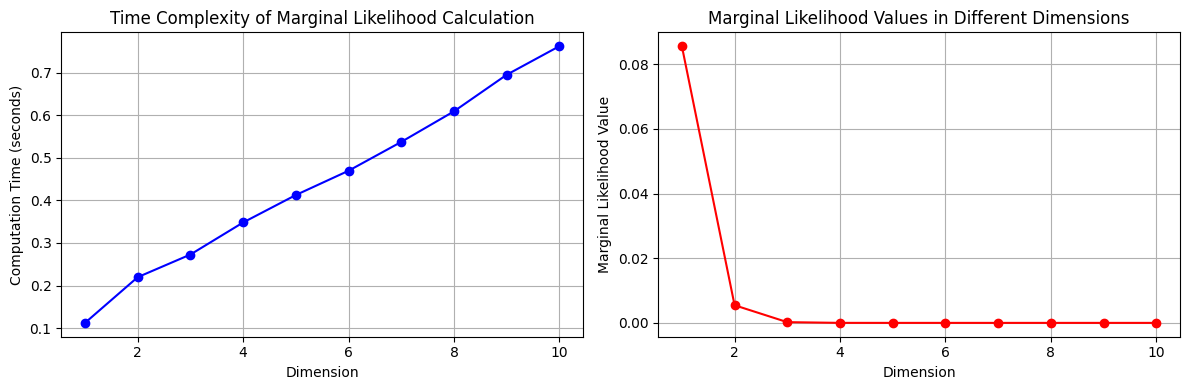

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

def prior(z):
    """Multivariate standard normal distribution prior"""
    if z.ndim == 1:
        z = z.reshape(1, -1)
    d = z.shape[1]
    return np.exp(-0.5 * np.sum(z**2, axis=1)) / ((2 * np.pi) ** (d/2))

def likelihood(x, z):
    """Multivariate normal distribution likelihood function"""
    if x.ndim == 1:
        x = x.reshape(1, -1)
    if z.ndim == 1:
        z = z.reshape(1, -1)
    d = x.shape[1]
    diff = x - z
    return np.exp(-0.5 * np.sum(diff**2, axis=1)) / ((2 * np.pi) ** (d/2))

def marginal_likelihood(x, n_samples=10000):
    """Calculate marginal likelihood p(x) = ∫ p(x|z)p(z)dz"""
    d = len(x) if isinstance(x, (list, np.ndarray)) else 1
    
    # Sample from prior distribution
    zs = np.random.normal(0, 1, (n_samples, d))
    
    # Calculate likelihood and prior
    x_array = np.array(x).reshape(1, -1)
    likelihoods = likelihood(x_array, zs)
    priors = prior(zs)
    
    # Monte Carlo integration
    return np.mean(likelihoods * priors)

# Test computational time complexity under different dimensions
dimensions = range(1, 11)  # 1 to 10 dimensions
times = []
results = []

print("Dimension\tTime(sec)\tMarginal Likelihood")
print("-" * 40)

for d in dimensions:
    # Generate d-dimensional observation x
    x = np.random.normal(0, 1, d)
    
    # Calculate time
    start_time = time.time()
    p_x = marginal_likelihood(x, n_samples=5000000)  # Reduce sampling to observe time differences
    end_time = time.time()
    
    computation_time = end_time - start_time
    times.append(computation_time)
    results.append(p_x)
    
    print(f"{d}\t{computation_time:.4f}\t\t{p_x:.13f}")

# Plot time complexity graph
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(dimensions, times, 'bo-')
plt.xlabel('Dimension')
plt.ylabel('Computation Time (seconds)')
plt.title('Time Complexity of Marginal Likelihood Calculation')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(dimensions, results, 'ro-')
plt.xlabel('Dimension')
plt.ylabel('Marginal Likelihood Value')
plt.title('Marginal Likelihood Values in Different Dimensions')
plt.grid(True)

plt.tight_layout()
plt.show()

当然了，二维情况下的边际似然自己手算还是可行的，但再往上解析解就很困难了，通常用数值解。除了蒙特卡洛方法（通过多次随机采样，可以得到积分的期望值），还有
- 重要性采样（Importance Sampling）：但需要选择一个合适的重要性分布；是蒙特卡洛方法的一种变体，通过从一个更容易采样的分布中采样，并根据样本的权重进行调整，来估算目标分布的积分；
- 拉普拉斯逼近（Laplace Approximation）：通过泰勒展开方法，近似目标分布（例如后验分布）为一个高斯分布。它利用目标分布的最大值附近的二阶导数来近似；但如果目标分布严重偏离高斯分布，拉普拉斯近似会偏离真实值；
- 马尔可夫链蒙特卡洛（MCMC）：通过构建马尔可夫链来逐步生成符合目标分布的样本，常用于高维和复杂的后验推断；

许多科学计算库提供了高效的数值积分工具，例如：
- `SciPy`：提供了 scipy.integrate 模块来进行数值积分。
- `PyMC3`：用于贝叶斯推断，提供了很多数值方法，包括马尔可夫链蒙特卡洛（MCMC）方法来计算后验分布。

In [18]:
import scipy.integrate as integrate

def integrand(z1, z2):
    return np.exp(-0.5 * (z1**2 + z2**2))

result, error = integrate.dblquad(integrand, -np.inf, np.inf, lambda x: -np.inf, lambda x: np.inf)
print("Numerical Integral:", result)

Numerical Integral: 6.283185307179598


变分贝叶斯的步骤：
- 定义后验分布：假设我们有观测数据 $x$ 和潜在变量 $z$，我们希望得到潜在变量 $z$ 的后验分布；
- 近似后验分布：直接计算后验分布 p(z | x) 通常非常困难，尤其是在高维空间中，因此我们引入一个变分分布 q(z)，它是一个简单的分布，用来近似真实的后验分布 p(z | x)；
- 优化变分分布：我们通过**最小化 Kullback-Leibler 散度（KL 散度）**来让变分分布 q(z) 尽可能接近真实后验分布 p(z | x)；
- 为了实现这一目标，变分贝叶斯使用了变分下界（ELBO）来简化计算；ELBO 是对数边际似然的下界，最大化 ELBO 等价于最小化 KL 散度：
	- 重构误差（即模型生成数据与真实数据之间的差异）
	- KL 散度（衡量近似后验与真实后验之间的差异）

VAE 的损失函数如下：
$$
\mathcal{L}(\theta, \phi; x) = \mathbb{E}_{q(z | x)} \left[ \log p(x | z) \right] - \text{KL}(q(z | x) || p(z))
$$

- 第一项是重构误差，它衡量通过解码器生成的数据与原始数据之间的差异；
- 第二项是 KL 散度，它衡量近似后验分布 q(z | x) 与先验分布 p(z) 之间的差异；
- 我们无法直接计算真实的后验分布，只需要最小化变分分布与先验分布之间的 KL 散度，并通过重构误差来间接地优化潜在空间。

重参数化技巧的目标就是将潜在变量的采样过程转化为一个确定性的过程，使得我们可以在训练时通过反向传播来更新模型的参数。将随机性移到一个标准正态分布的噪声变量 $\epsilon$ 上，并通过均值和标准差的变换来得到 z。保证梯度的顺利流通。

Epoch 1, Total Loss: 176.4196, Recon: 168.5735, KL: 7.8460
Epoch 2, Total Loss: 127.3302, Recon: 112.1861, KL: 15.1441
Epoch 3, Total Loss: 116.6475, Recon: 99.8568, KL: 16.7906
Epoch 4, Total Loss: 112.4334, Recon: 94.9127, KL: 17.5207
Epoch 5, Total Loss: 109.6121, Recon: 91.4624, KL: 18.1497
Epoch 6, Total Loss: 107.6230, Recon: 89.0714, KL: 18.5516
Epoch 7, Total Loss: 106.2316, Recon: 87.4472, KL: 18.7843
Epoch 8, Total Loss: 105.2069, Recon: 86.2635, KL: 18.9434
Epoch 9, Total Loss: 104.3743, Recon: 85.2872, KL: 19.0871
Epoch 10, Total Loss: 103.6682, Recon: 84.5036, KL: 19.1646
Epoch 11, Total Loss: 103.0624, Recon: 83.8078, KL: 19.2546
Epoch 12, Total Loss: 102.5448, Recon: 83.2329, KL: 19.3119
Epoch 13, Total Loss: 102.1277, Recon: 82.7348, KL: 19.3929
Epoch 14, Total Loss: 101.7618, Recon: 82.3100, KL: 19.4518
Epoch 15, Total Loss: 101.3948, Recon: 81.9307, KL: 19.4641
Epoch 16, Total Loss: 101.0616, Recon: 81.5637, KL: 19.4980
Epoch 17, Total Loss: 100.8123, Recon: 81.2469, 

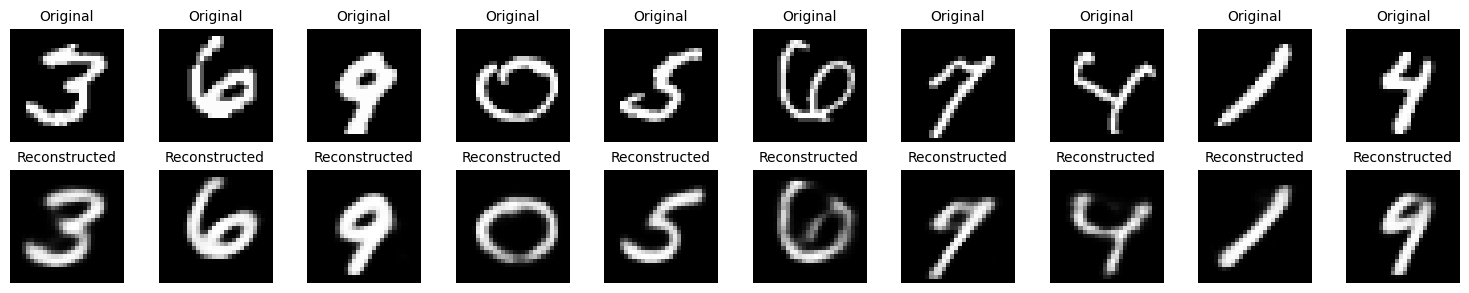

Generating new images from latent space...


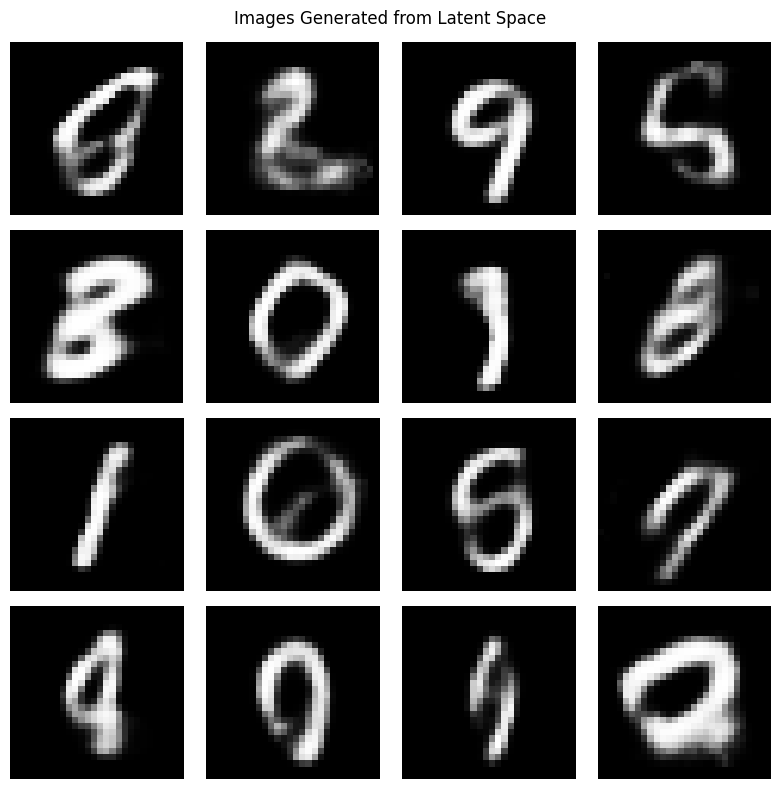

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F


class VAE(nn.Module):
    def __init__(self, latent_dim=20):  # Reduce latent dimension
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder: map input image to latent space (mean, log_var)
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2)  # Output mean and log variance
        )
        
        # Decoder: generate image from latent space
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mean = h[:, :self.latent_dim]
        log_var = h[:, self.latent_dim:]
        return mean, log_var

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        x = x.view(-1, 28*28)
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decode(z)
        return reconstructed_x, mean, log_var

transform = transforms.Compose([
    transforms.ToTensor(),
    # Remove Normalize, keep data in [0,1] range
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# 4. Improved model training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=20).to(device)  # Use smaller latent dimension
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 20  # Increase training epochs
beta = 1.0   # KL divergence weight

for epoch in range(epochs):
    model.train()
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        reconstructed_data, mean, log_var = model(data)
        
        # Calculate losses
        batch_size = data.size(0)
        recon_loss = F.binary_cross_entropy(reconstructed_data, data.view(-1, 28*28), reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        
        loss = (recon_loss + beta * kl_loss) / batch_size
        
        loss.backward()
        train_loss += loss.item()
        recon_loss_total += recon_loss.item() / batch_size
        kl_loss_total += kl_loss.item() / batch_size
        
        optimizer.step()
    
    avg_loss = train_loss / len(train_loader)
    avg_recon = recon_loss_total / len(train_loader) 
    avg_kl = kl_loss_total / len(train_loader)
    
    print(f"Epoch {epoch + 1}, Total Loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}")

# 5. Visualization of results comparison
model.eval()
with torch.no_grad():
    sample_data, _ = next(iter(train_loader))
    sample_data = sample_data.to(device)
    reconstructed_sample, _, _ = model(sample_data)
    
    # Original vs reconstructed images comparison
    fig, axes = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        # Original image
        axes[0, i].imshow(sample_data[i].cpu().squeeze(), cmap='gray')
        axes[0, i].set_title('Original', fontsize=10)
        axes[0, i].axis('off')
        
        # Reconstructed image
        axes[1, i].imshow(reconstructed_sample[i].cpu().squeeze().view(28, 28), cmap='gray')
        axes[1, i].set_title('Reconstructed', fontsize=10)  
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# 6. Generate new images from latent space
print("Generating new images from latent space...")
with torch.no_grad():
    z = torch.randn(16, 20).to(device)  # Sample from standard normal distribution
    generated = model.decode(z)
    
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(16):
        row, col = i // 4, i % 4
        axes[row, col].imshow(generated[i].cpu().view(28, 28), cmap='gray')
        axes[row, col].axis('off')
    
    plt.suptitle('Images Generated from Latent Space')
    plt.tight_layout()
    plt.show()


额外的诊断工具，分析潜在空间质量。确保潜在变量不偏离 0 均值和稳定方差；如果各维度KL散度不平衡，可能存在后验崩塌，考虑使用 β-VAE 退火策略或减少潜在空间的维度。

- Mean absolute mean: 0.4500 
- Mean variance: 0.4687 
- KL divergence per dimension: 0.9896
- KL divergence standard deviation: 0.9821 


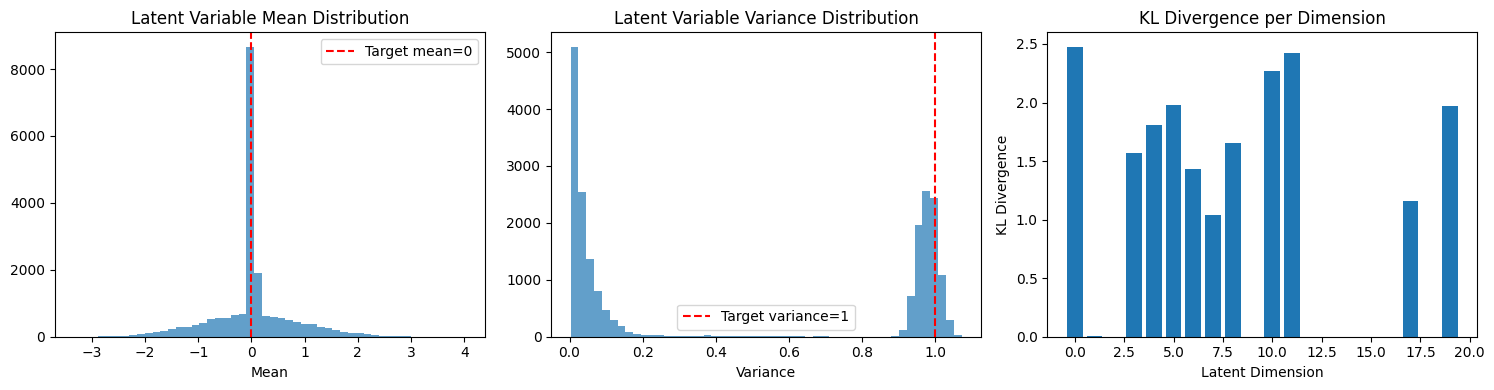

In [ ]:
def analyze_latent_space(model, data_loader, device, num_samples=1000):
    """Analyze quality metrics of the latent space"""
    model.eval()
    
    means = []
    log_vars = []
    
    with torch.no_grad():
        for i, (data, _) in enumerate(data_loader):
            if i * data_loader.batch_size >= num_samples:
                break
                
            data = data.to(device)
            _, mean, log_var = model(data)
            means.append(mean.cpu())
            log_vars.append(log_var.cpu())
    
    means = torch.cat(means, dim=0)
    log_vars = torch.cat(log_vars, dim=0)
    
    # Calculate key metrics
    mean_abs_mean = torch.mean(torch.abs(means)).item()
    mean_var = torch.mean(torch.exp(log_vars)).item()
    kl_per_dim = -0.5 * torch.mean(1 + log_vars - means.pow(2) - log_vars.exp(), dim=0)
    
    print(f"- Mean absolute mean: {mean_abs_mean:.4f} ")
    print(f"- Mean variance: {mean_var:.4f} ")
    print(f"- KL divergence per dimension: {kl_per_dim.mean().item():.4f}")
    print(f"- KL divergence standard deviation: {kl_per_dim.std().item():.4f} ")
    
    return means, log_vars, kl_per_dim


means, log_vars, kl_per_dim = analyze_latent_space(model, train_loader, device)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Mean distribution
axes[0].hist(means.numpy().flatten(), bins=50, alpha=0.7)
axes[0].set_title('Latent Variable Mean Distribution')
axes[0].set_xlabel('Mean')
axes[0].axvline(0, color='red', linestyle='--', label='Target mean=0')
axes[0].legend()

# Variance distribution
axes[1].hist(torch.exp(log_vars).numpy().flatten(), bins=50, alpha=0.7)
axes[1].set_title('Latent Variable Variance Distribution')
axes[1].set_xlabel('Variance')
axes[1].axvline(1, color='red', linestyle='--', label='Target variance=1')
axes[1].legend()

# KL divergence per dimension
axes[2].bar(range(len(kl_per_dim)), kl_per_dim.numpy())
axes[2].set_title('KL Divergence per Dimension')
axes[2].set_xlabel('Latent Dimension')
axes[2].set_ylabel('KL Divergence')

plt.tight_layout()
plt.show()
